In [1]:
import os, json, pickle, time, random, copy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
os.chdir('D:/L3/network')
from transport_network import Transport_Network, viz_path
%matplotlib inline

In [2]:
tn = Transport_Network('Shenzhen')
mode = 'driving'

In [3]:
grids = json.load(open('cities/Shenzhen/clean/grid1_4326.geojson', 'r'))['features']
positions = [tuple(np.array(g['geometry']['coordinates'][0][:4]).mean(axis=0)) 
             for g in grids]

# Check Whether Two Algorithms Return the Same Result

The two paths are same
Traffic time: fw = 362.4012 seconds, dijkstra = 362.4012 seconds
Traffic time: fw = 3018.8018 meters, dijkstra = 3018.8018 meters


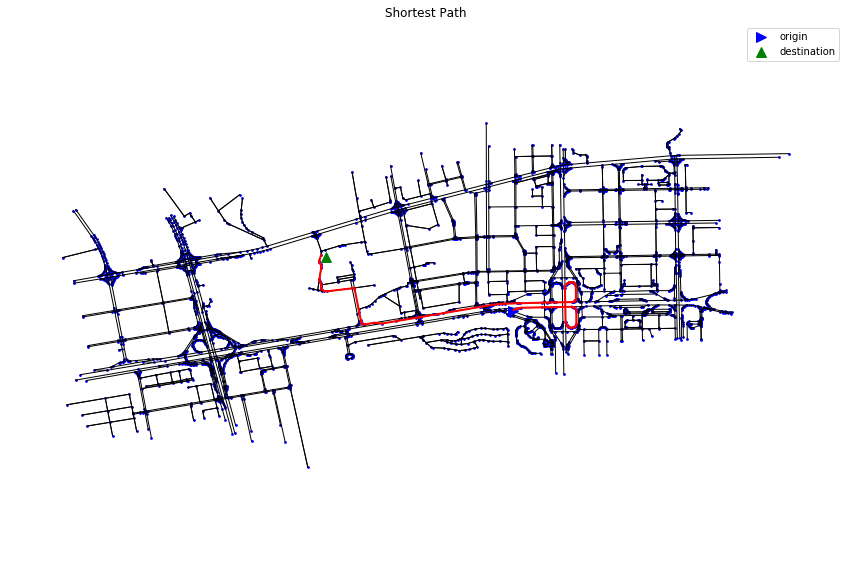

In [4]:
from_coord = random.choice(positions)
to_coord = random.choice(positions)
while to_coord == from_coord:
    to_coord = random.choice(positions)
    
method = 'dijkstra'

routes_fw = tn.get_routes(from_coord, to_coord, num_nearest_nodes=5, method='fw')
routes_dij = tn.get_routes(from_coord, to_coord, num_nearest_nodes=5, method=method)

if routes_fw == routes_dij:
    print('The two paths are same')
else:
    print('The two paths are not the same')
print('Traffic time: fw = {:4.4f} seconds, dijkstra = {:4.4f} seconds'.format(
    sum(routes_fw['driving']['minutes'])*60, sum(routes_dij['driving']['minutes'])*60))
print('Traffic time: fw = {:4.4f} meters, dijkstra = {:4.4f} meters'.format(
    routes_fw['driving']['total_distance'], routes_dij['driving']['total_distance']))


# visulization
%matplotlib inline
if routes_fw != routes_dij:
    fig, axes = plt.subplots(2, 1, figsize=(15,10))
    fig.tight_layout()
    viz_path(from_coord, to_coord, routes_fw, tn ,mode, 
             ax=axes[0], title='Shortest Path Based on Precooked FW Algorithm')
    viz_path(from_coord, to_coord, routes_dij, tn ,mode, 
             ax=axes[1], title='Shortest Path Basedon Dijstra Algorithm')
else:
    fig = plt.figure(figsize=(15,10))
    viz_path(from_coord, to_coord, routes_fw, tn ,mode, 
             title='Shortest Path')
plt.show()

# Compare Speed between Precooked (FW) and RealTime (Dijkstra) 

Run three algorithms 10000 times, already done and results are saved to local file  
Running machine: cpu=i5-7300u, ram=8g

In [5]:
different_result_count_dij = 0
different_result_count_bf = 0
trial_num = 10000
fw_calc_time = []
dij_calc_time = []
bf_calc_time = []

for idx in range(trial_num):
    from_coord = random.choice(positions)
    to_coord = random.choice(positions)
    while to_coord == from_coord:
        to_coord = random.choice(positions)
        
    from_nodes = tn.get_closest_internal_nodes(from_coord, 5)[mode]
    to_nodes = tn.get_closest_internal_nodes(to_coord, 5)[mode]
        
    t0 = time.time()
    path_fw = tn.get_node_path_from_fw_try_multi(
        from_nodes, to_nodes, mode, method='fw')
    t1 = time.time()
    path_dij = tn.get_node_path_from_fw_try_multi(
        from_nodes, to_nodes, mode, method='dijkstra')
#     dijkstra
    t2 = time.time()
    path_bf = tn.get_node_path_from_fw_try_multi(
        from_nodes, to_nodes, mode, method='bellman-ford')
    t3 = time.time()
    fw_calc_time.append(t1-t0)
    dij_calc_time.append(t2-t1)
    bf_calc_time.append(t3-t2)
    if path_fw != path_dij:
        different_result_count_dij += 1
    if path_fw != path_bf:
        different_result_count_bf += 1
    
compare_speed_rst = {
    'different_result_count_dij': different_result_count_dij,
    'different_result_count_bf': different_result_count_bf,
    'fw_calc_time': fw_calc_time,
    'dij_calc_time': dij_calc_time,
    'bf_calc_time': bf_calc_time
}
json.dump(compare_speed_rst, open('compare_speed_rst.json', 'w'), indent=4)

## Results

From mean/median/95th-percentile and plots below it is clear that:  
Running a Dijkstra (or Bellman-ford) algorithm to find shortest path in realtime is significantly slower than fetching the path from precooked results by FW algorithm

In [6]:
compare_speed_rst = json.load(open('compare_speed_rst.json', 'r'))
fw_calc_time = compare_speed_rst['fw_calc_time']
dij_calc_time = compare_speed_rst['dij_calc_time']
bf_calc_time = compare_speed_rst['bf_calc_time']
print('Precooked approach: mean={:4.4f}, median={:4.4f}, P95={:4.4f}'.format(
    np.mean(fw_calc_time), np.median(fw_calc_time),
    np.percentile(fw_calc_time, 95)))
print('Dijstra algorithm: mean={:4.4f}, median={:4.4f}, P95={:4.4f}'.format(
    np.mean(dij_calc_time), np.median(dij_calc_time), 
    np.percentile(dij_calc_time, 95)))
print('Bellman-ford algorithm: mean={:4.4f}, median={:4.4f}, P95={:4.4f}'.format(
    np.mean(bf_calc_time), np.median(bf_calc_time),
    np.percentile(bf_calc_time, 95)))

Precooked approach: mean=0.0001, median=0.0000, P95=0.0010
Dijstra algorithm: mean=0.0178, median=0.0060, P95=0.0289
Bellman-ford algorithm: mean=0.0946, median=0.0509, P95=0.1769


## Boxplot Comparison

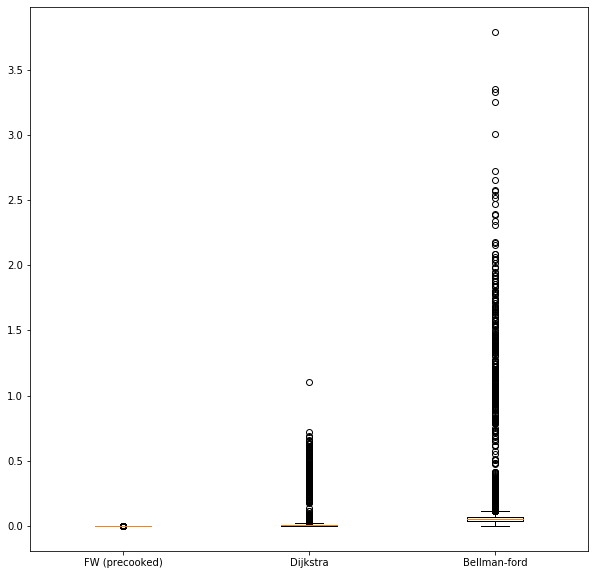

In [7]:
%matplotlib inline
data = [fw_calc_time, dij_calc_time, bf_calc_time]
fig = plt.figure(figsize=(10,10))
_ = plt.boxplot(data, labels=['FW (precooked)', 'Dijkstra', 'Bellman-ford'])

## Boxplot comparison after removing ODs taking more than 0.1 second to find the shortest path 

C:\Users\tiamo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


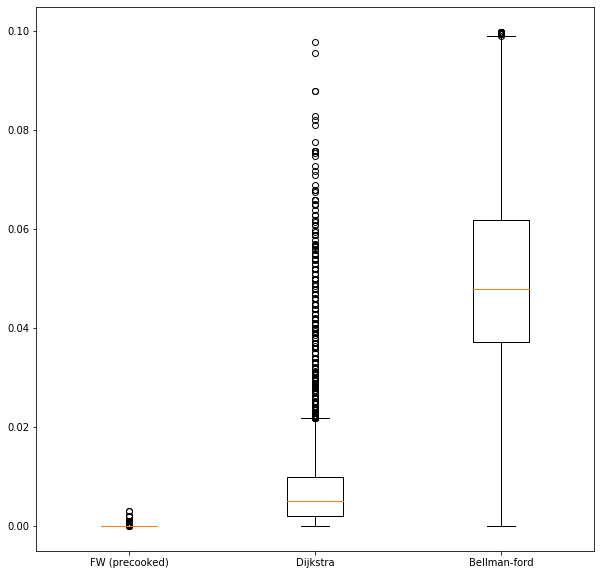

In [8]:
cutoff = 0.1
data = [
    [x for x in fw_calc_time if x<cutoff], 
    [x for x in dij_calc_time if x<cutoff], 
    [x for x in bf_calc_time if x<cutoff]
]

fig = plt.figure(figsize=(10,10))
_ = plt.boxplot(data, labels=['FW (precooked)', 'Dijkstra', 'Bellman-ford'])

## Time Distribution Comparison

C:\Users\tiamo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


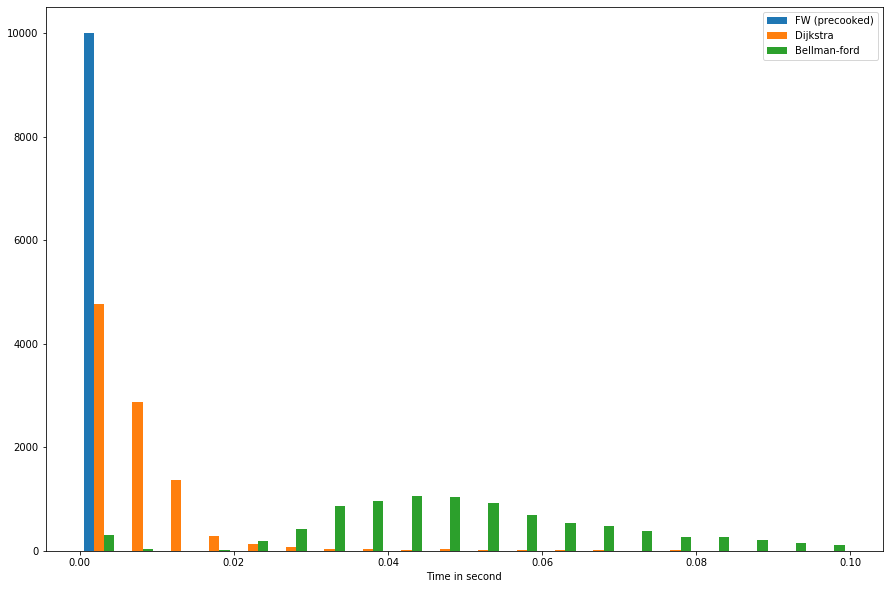

In [9]:
cutoff = 0.1
data = [
    [x for x in fw_calc_time if x<cutoff], 
    [x for x in dij_calc_time if x<cutoff], 
    [x for x in bf_calc_time if x<cutoff]
]
nbins = 20
fig = plt.figure(figsize=(15,10))
_ = plt.hist(data, nbins, label=['FW (precooked)', 'Dijkstra ', 'Bellman-ford'])
plt.xlabel('Time in second')
plt.legend()

# Add New Link

Basically we could add arbitary new links to the network, for instance, a directly link from origin to destination with very delibrately low cost. Then we modify the network graphic and Dijkstra could give us the updated shortest path correctly in realtime.   
The only problem is it takes time to calculate in realtime

In [10]:
tn2 = copy.deepcopy(tn)

Add new link to network took 0.0020 seconds
The two paths are not the same
Traffic time: fw = 382.7463 seconds, dijkstra = 6.0000 seconds
Traffic time: fw = 3188.2764 meters, dijkstra = 0.1000 meters


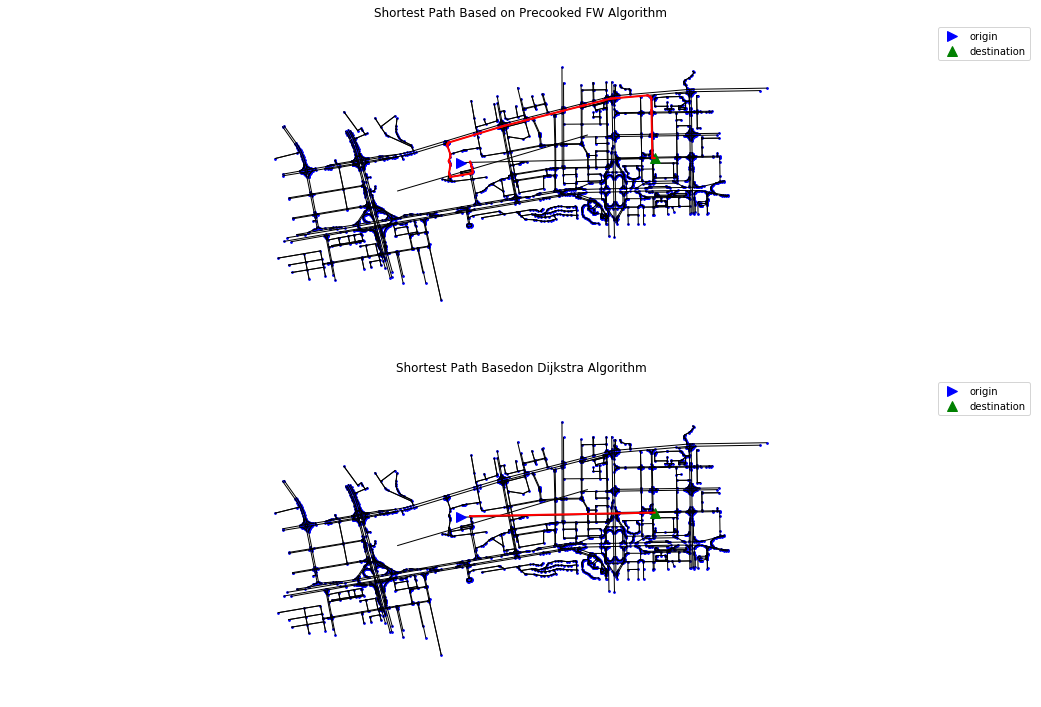

In [12]:
from_coord = random.choice(positions)
to_coord = random.choice(positions)
while to_coord == from_coord:
    to_coord = random.choice(positions)
    
method = 'dijkstra'

t0 = time.time()
from_node = tn2.get_closest_internal_nodes(from_coord, 5)[mode][0]
to_node = tn2.get_closest_internal_nodes(to_coord, 5)[mode][0]
tn2.sim_network[mode].add_edge(from_node, to_node, weight=0.1)
tn2.nodes_to_link_attributes[mode]['{}_{}'.format(from_node, to_node)] = {
    'distance': 0.1,
    'from_coord': from_coord,
    'to_coord': to_coord,
    'activity': None,
    'minutes': 0.1
}
t1 = time.time()
print('Add new link to network took {:4.4f} seconds'.format(t1-t0))

routes_fw = tn2.get_routes(from_coord, to_coord, num_nearest_nodes=5, method='fw')
routes_dij = tn2.get_routes(from_coord, to_coord, num_nearest_nodes=5, method=method)

if routes_fw == routes_dij:
    print('The two paths are same')
else:
    print('The two paths are not the same')
print('Traffic time: fw = {:4.4f} seconds, dijkstra = {:4.4f} seconds'.format(
    sum(routes_fw['driving']['minutes'])*60, sum(routes_dij['driving']['minutes'])*60))
print('Traffic time: fw = {:4.4f} meters, dijkstra = {:4.4f} meters'.format(
    routes_fw['driving']['total_distance'], routes_dij['driving']['total_distance']))


# visulization
%matplotlib inline
if routes_fw != routes_dij:
    fig, axes = plt.subplots(2, 1, figsize=(15,10))
    fig.tight_layout()
    viz_path(from_coord, to_coord, routes_fw, tn2 ,mode, 
             ax=axes[0], title='Shortest Path Based on Precooked FW Algorithm')
    viz_path(from_coord, to_coord, routes_dij, tn2 ,mode, 
             ax=axes[1], title='Shortest Path Basedon Dijkstra Algorithm')
else:
    fig = plt.figure(figsize=(15,10))
    viz_path(from_coord, to_coord, routes_fw, tn2 ,mode, 
             title='Shortest Path')
plt.show()